## Regression with Unknown Feature Names

#### Author Information:

Oguz Semerci<br>
oguz.semerci@gmail.com<br>

### Summary of the investigation

We have in hand a regression problem with 5000 observations and 254 features, whose names are not known. The number of features is fairly large and we are expected to report on the important features. Therefore we it will be sensible to use a model that appropriatly regularize the outcome and automatically perform 'feature-selection'. ***Lasso*** is perfect for that as it uses an ***L1 norm penalty*** on the coefficient vector and promotes sparsity.

In addition to Lasso, we performed ***random forest regression***, which outperformed Lasso on the training set. To compute the optimal regularization parameter for Lasso, we empleyed a ***cross validation*** approach. Similarly, we determined optimal number of trees and number of features for the random forrest regresssor via a small scale ***grid search*** powered by cross validation.

Random forrest classifer also gives importance score for each feature in terms of average reduction in the variance for each cut in that feature. We also report on the ***importantance of features as determined by random forrest regressor***, and compare those with the ones selected by Lasso.

Since we have fairly good amount of data we also measured the performance of both models with ***unseen data***. For that we set side 20% of the data as a test set. Perhaps surprisingly Lasso outperformed random forest regressor on the test set. one could try to increase the number of trees in the random forest model to overcome its overfitting issues with this particular problem. Nevertheless we already tried up to 30 trees and maybe Lasso is just a better choice.
 
Other feature selection methods such as forward selection where features are added one at a time could have been used. We will omit more complex feature engineering methods such as considering higher order terms and correlation analysis to add new features to incorporate interactions.

Some comments on the qualty of the data set and the data cleaning methods that were employed are given next.

### I- Data Preparation

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

A quick visual investigation of the 'codetest.train.text' file reveals that some of the features are categorical. Also there are missing entries that needs to be taken care of.

Let's do the initial analysis using Pandas.

In [4]:
#load the given data set
import os
import pandas as pd

train_data_path = os.path.join('data', 'codetest_train.txt')
test_data_path = os.path.join('data', 'codetest_test.txt')
df_train = pd.read_csv(train_data_path, sep = '\t')
df_test = pd.read_csv(test_data_path, sep = '\t')

Let's list the categorical features and their unique values:

In [5]:
categorical_keys = []
for key,dt in zip(df_train.keys(), df_train.dtypes):
    if dt != 'float64':
        categorical_keys.append(key)
        print('{}: {}'.format(key,dt))
        print(df_train[key].unique())
        print(df_train[key].describe())
        print('')

f_61: object
['b' 'a' 'd' 'c' nan 'e']
count     4905
unique       5
top          d
freq      1015
dtype: object

f_121: object
['D' 'A' 'B' 'C' 'E' 'F' nan]
count     4914
unique       6
top          B
freq       837
dtype: object

f_215: object
['red' 'blue' 'orange' 'yellow' nan]
count     4898
unique       4
top        red
freq      1294
dtype: object

f_237: object
['Canada' 'USA' 'Mexico' nan]
count       4905
unique         3
top       Canada
freq        1677
dtype: object



Let's impute missing categorical features with 'top' values, and regular features with 'mean'. 

In [6]:
for key in df_train.keys():
    if key in categorical_keys:
        df_train[key] = df_train[key].fillna(df_train[key].mode()[0])
    else:
        df_train[key] = df_train[key].fillna(df_train[key].mean())
        
for key in df_test.keys():
    if key in categorical_keys:
        df_test[key] = df_test[key].fillna(df_train[key].mode()[0])
    else:
        df_test[key] = df_test[key].fillna(df_train[key].mean())

As a sanity check let's make sure we imputed the 'nan' values from categorical features.

In [7]:
for key,dt in zip(df_train.keys(), df_train.dtypes):
    if dt != 'float64':
        categorical_keys.append(key)
        print('{}: {}'.format(key,dt))
        print(df_train[key].unique())
        print(df_train[key].describe())
        print('')

f_61: object
['b' 'a' 'd' 'c' 'e']
count     5000
unique       5
top          d
freq      1110
dtype: object

f_121: object
['D' 'A' 'B' 'C' 'E' 'F']
count     5000
unique       6
top          B
freq       923
dtype: object

f_215: object
['red' 'blue' 'orange' 'yellow']
count     5000
unique       4
top        red
freq      1396
dtype: object

f_237: object
['Canada' 'USA' 'Mexico']
count       5000
unique         3
top       Canada
freq        1772
dtype: object



Let's make sure the features have unit standard deviation since we'll be using Lasso.

In [8]:
for key in df_train.keys():
    if key not in categorical_keys and key != 'target':
        std = df_train[key].std()
        df_train[key] = df_train[key] / std
        df_test[key]  = df_test[key]  / std

Convert the Pandas data frame to Numpy arrays.

In [9]:
# I learned this trick of going from a data frame to a python dictionary from the following post:
# http://stackoverflow.com/questions/20024584/vectorizing-a-pandas-dataframe-for-scikit-learn
# note the first index in the df.keys() is the 'target' vector
X_train = df_train[list(df_train.keys())[1:]].T.to_dict().values()
X_test  = df_test.T.to_dict().values()
Y_train = df_train['target'].values

Now we'll use scikit-learn's DictVectorizer method to encode the categorical variables using one-hot encoding.

In [10]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec.fit(X_train)
X_train = vec.transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

Now we have the the data in the format scikit-learn expects.

Compute basic statistics of the target vector and plot its boxplot and histogram.

In [11]:
print('Statistics for the target vector in training data:')
print('--------------------------------')
print('98th percentile : {:.2f}'.format(np.percentile(Y_train, 98)))
print('75th percentile : {:.2f}'.format(np.percentile(Y_train, 75)))
print('2th percentile  : {:.2f}'.format(np.percentile(Y_train, 5))) 
print('median          : {:.2f}'.format(np.median(Y_train)))
print('mean            : {:.2f}'.format(np.mean(Y_train)))
print('std             : {:.2f}'.format(np.std(Y_train)))

Statistics for the target vector in training data:
--------------------------------
98th percentile : 11.94
75th percentile : 4.44
2th percentile  : -7.46
median          : 1.17
mean            : 1.14
std             : 5.26


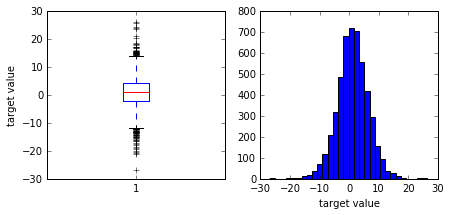

In [12]:
fig = plt.figure(figsize = (7,3))
ax1 = plt.subplot(121)
ax1.boxplot(Y_train)
ax1.set_ylabel('target value')
ax2 = plt.subplot(122)
_, _,_ = ax2.hist(Y_train,bins = 30)
ax2.set_xlabel('target value')
plt.show()

One can argue that values outside the interval [-20,20] are outliers. Yet they could contain useful information as well. Note that the number of data points is much larger than number of features, and we'll be using a regularized fit. So let's keep the larger observations in the data set.

### II- Model Selection

Since we decided to leave feature engineering to Lasso, the only crucial element in the model selection procedure is the tuning of the regularization parameter. We will leave this task to scikit-learn's LassoCV method which automatically finds the best value using cross validation. We chose to use 10-fold cross validation. Specifically we need to pick an optimal $\alpha$ for the following minimization problem:

$\min_{ \beta \in \mathbb{R}^p } \left\{ \frac{1}{2N} \left\| Y - X \beta \right\|_2^2 + \alpha \| \beta \|_1 \right\}$,

where $\beta$ is the unknown parameter vector, N is the number of samples, and $X$ and $Y$ are training data and target vector repectively.

/Users/oguzsemerci/anaconda/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/Users/oguzsemerci/anaconda/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


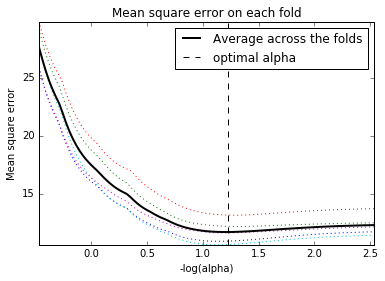

Optimal alpha: 0.06
R2 with Lasso: 0.591688
MSE with Lasso: 11.294297


In [41]:
#The code in this cell is partially borrowed from here: http://bit.ly/1JPHF2x
# LassoCV: 
from sklearn.linear_model import LassoCV
model = LassoCV(cv=5).fit(X_train, Y_train)

# list of alphas that were tried-out
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='optimal alpha')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.show()

from sklearn.metrics import mean_squared_error
Y_predict = model.predict(X_train)
r2 = model.score(X_train, Y_train)
mse = mean_squared_error(Y_predict, Y_train)

print('Optimal alpha: {:.2f}'.format(model.alpha_))
print('R2 with Lasso: {:.6f}'.format(r2))
print('MSE with Lasso: {:.6f}'.format(mse))

The above plot nicely demonstrates the MSE error as a funciton of the regularization parameter $\alpha$. The optimal value is picked right where the average (over all cross validation errors) MSE is minimum (rigth before it increases again due to over-regularization).

Let's visualize given target vector with our prediction for the first 100 data instances.

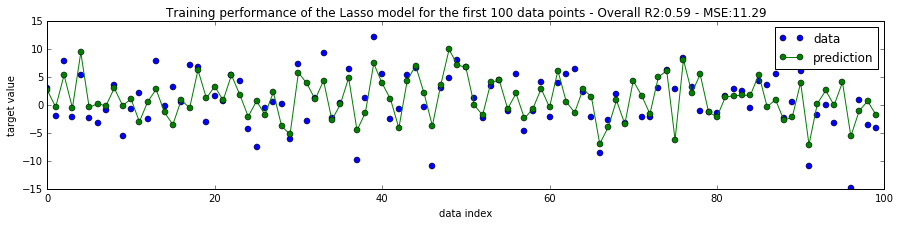

In [42]:
fig = plt.figure(figsize=(15,3))
plt.plot(Y_train[:100], 'o', label = 'data')
plt.plot(Y_predict[:100], '-o',color = 'g', label = 'prediction')
plt.legend()
plt.xlabel('data index')
plt.ylabel('target value')
title = ['Training performance of the Lasso model for the first 100 data points -' +
          ' Overall R2:' + str(round(r2,2)) +  ' - MSE:' + str(round(mse,2))]
plt.title(title[0])
plt.ylim([-15,15])
plt.show()

Let's find out which parameters are set to zero by the L1 regularizer:

In [43]:
beta = model.coef_
feature_indexes = []
feature_names   = []
feature_coeffs  = []
for i,b in enumerate(beta):
    if b>0:
        feature_indexes.append(i)
        feature_names.append(vec.feature_names_[i])
        feature_coeffs.append(model.coef_[i])
        #print('{:5s}: {:.4}'.format(vec.feature_names_[i],b))
print('{} features with nonzero coefficients:'.format(len(feature_names)))
feature_coeffs, feature_names = zip(*(sorted(zip(feature_coeffs, feature_names),reverse = True)))

37 features with nonzero coefficients:


Note that only 37 features were selected to be important by Lasso. Next, let's take a look at the coefficient values of selected features.

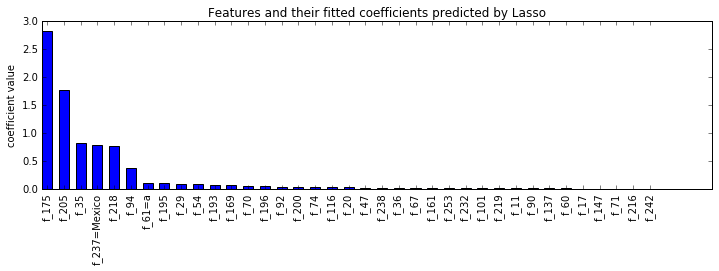

In [44]:
width = 0.6
fig = plt.figure(figsize = (12,3))
ax  = plt.subplot(111)
ax.bar(range(len(feature_coeffs)), feature_coeffs, width = width)
ax.set_xticks(np.arange(len(feature_coeffs)) + width/2)
ax.set_xticklabels(feature_names, rotation = 90)
ax.set_title('Features and their fitted coefficients predicted by Lasso')
ax.set_ylabel('coefficient value')
plt.show()

As observed from the above bar plot the most effective features are f_175 and f_205 within the framework of our model. More specifically, a unit standard deviation (computed using the training data) increase in the features shown above will result in an increase in the target vector given by the coefficients given above. Note that this insight is only valid for our linear model and one should avoid comments on causality as the correlation, independance or interaction between features are not considered. 

We conclude the feature analysis here. The important features selected by the Lasso regression is given above. Their predictive power could further be investigated via a more detailed analysis of the coefficient values and perhaps their p-values.

Below we try out two more methods:

- Least squares fit to a linear model with features selected by Lasso
- Random forest regressor 

#### Ordinary Least Squares with Selected Features

Let's create a new training set with only the important features and see if we'll improveon the R2 performance using a ordinary least squares fit:

In [45]:
#manually add the missing categorical features for f_237 and f_61"
for key in vec.vocabulary_.keys():
    if 'f_237' in key or 'f_61' in key:
            feature_indexes.append(vec.vocabulary_[key])
feature_indexes = set(feature_indexes)

In [46]:
X_train2 = X_train[:,list(feature_indexes)]
X_test2  = X_test[:,list(feature_indexes)]

In [47]:
from sklearn.linear_model import LinearRegression
olr = LinearRegression()
olr.fit(X_train2,Y_train)
Y_predict2 = olr.predict(X_train2)
mse2 = mean_squared_error(Y_predict2, Y_train)
r22 = olr.score(X_train2, Y_train)

print('R2 with ordinary linear regression with selected features: {:.6f}'.format(r22))
print('MSE with ordinary linear regression with selected features: {:.6f}'.format(mse2))

R2 with ordinary linear regression with selected features: 0.595717
MSE with ordinary linear regression with selected features: 11.182850


#### Random Forests Regresssor

Random forrests are good as they control overtiffing by averaging the results from lots of trees fitted into data. Let's devise a quick grid search random forrest regressor and see how we'll do.

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search

parameters = {'max_features': ('sqrt', 'log2'), 'n_estimators': [5,10,15,20,25,30]}
rf = RandomForestRegressor()
model_rf = grid_search.GridSearchCV(rf, parameters, cv = 5)
model_rf.fit(X_train, Y_train)

Y_predict = model_rf.predict(X_train)
mse3 = mean_squared_error(Y_predict, Y_train)
r23 = model_rf.score(X_train, Y_train)

print('Random Forest R2: {}'.format(r23))
print('Random Forest MSE: {}'.format(mse3))
print('\nParameters Selected by Grid Search:')
print(model_rf.best_params_)

Random Forest R2: 0.9029689846390325
Random Forest MSE: 2.683972519016186

Parameters Selected by Grid Search:
{'max_features': 'sqrt', 'n_estimators': 30}


We can access the importance of the features according to the random foorrest classifier as well. `feature_importances_` atrribute of the random forrest classfier will give an importance of each feature according the average reduction in the variance due to all the cuts in that feature.

In [48]:
#first generate a rf regressor with determinded paremeters
model_rf = RandomForestRegressor(max_features = params['max_features'], n_estimators = params['n_estimators'])
model_rf.fit(X_train, Y_train)
Y_predict = model_rf.predict(X_train)
mse3 = mean_squared_error(Y_predict, Y_train)
r23 = model_rf.score(X_train, Y_train)

print('Random Forest R2: {}'.format(r23))
print('Random Forest MSE: {}'.format(mse3))

Random Forest R2: 0.8985024083292419
Random Forest MSE: 2.8075223759868613


In [49]:
feature_names_rf = []
for i, v in enumerate(model_rf.feature_importances_):
    feature_names_rf.append(vec.feature_names_[i])
    
std = np.mean([tree.feature_importances_ for tree in model_rf.estimators_], axis = 0)

feature_names_rf, feature_importance, std = zip(*sorted(
        zip(feature_names_rf, model_rf.feature_importances_, std), key = lambda x: x[1], reverse = True))

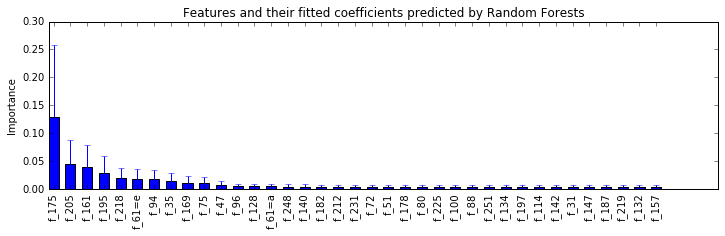

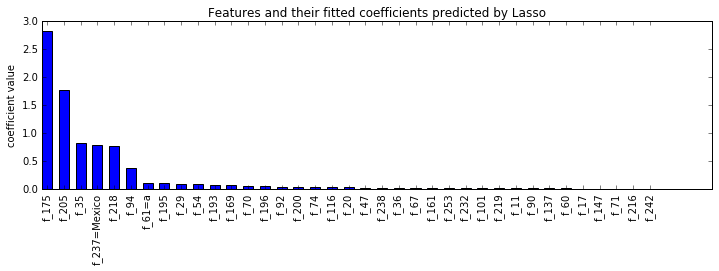

In [50]:
width = 0.6
fig = plt.figure(figsize = (12,3))
ax  = plt.subplot(111)
ax.bar(range(37), feature_importance[:37], width = width, yerr = std[:37])
ax.set_xticks(np.arange(37) + width/2)
ax.set_xticklabels(feature_names_rf[:37], rotation = 90)
ax.set_title('Features and their fitted coefficients predicted by Random Forests')
ax.set_ylabel('Importance')

width = 0.6
fig = plt.figure(figsize = (12,3))
ax  = plt.subplot(111)
ax.bar(range(len(feature_coeffs)), feature_coeffs, width = width)
ax.set_xticks(np.arange(len(feature_coeffs)) + width/2)
ax.set_xticklabels(feature_names, rotation = 90)
ax.set_title('Features and their fitted coefficients predicted by Lasso')
ax.set_ylabel('coefficient value')
plt.show()

plt.show()

As shown in the figures above two most important fetures determined random forrest and Lasso are `f_175` and `f_205`. Let's look at the common features among the most important 15 features returned by each model:

In [51]:
for name in set(feature_names_rf[:15]) & set(feature_names[:15]):
    print(name)

f_169
f_175
f_35
f_61=a
f_205
f_94
f_218
f_195


Cool, eight among most important fifteen features for each model are common. We can now be more confident and say that the features above are the most important ones.

#### Random Forests Regresssor - Caution against multiple comparison

Although our grid search did not cover high number of combinations of hyperparameters we may want to make sure that the good training set error is not achieved by chance. One solution is to set aside a portion of the training set and perform a final test on that portion of the training set which has not been seen by the model before.:

In [39]:
from sklearn.cross_validation import train_test_split

X_train_train, X_train_test, Y_train_train, Y_train_test = train_test_split(X_train, Y_train, test_size = 0.2)

model_rf2 = grid_search.GridSearchCV(rf, parameters, cv = 4)
model_rf2.fit(X_train_train, Y_train_train)

Y_predict = model_rf2.predict(X_train_train)
mse3 = mean_squared_error(Y_predict, Y_train_train)
r23 = model_rf2.score(X_train_train, Y_train_train)

print('Random Forest train R2: {}'.format(r23))
print('Random Forest train MSE: {}'.format(mse3))
print('\nParameters Selected by Grid Search:')
print(model_rf2.best_params_)

Y_predict = model_rf2.predict(X_train_test)
mse3 = mean_squared_error(Y_predict, Y_train_test)
r23 = model_rf2.score(X_train_test, Y_train_test)

print('\nRandom Forest test R2: {}'.format(r23))
print('Random Forest test MSE: {}'.format(mse3))

Random Forest train R2: 0.8973349676816934
Random Forest train MSE: 2.8082340974621594

Parameters Selected by Grid Search:
{'max_features': 'sqrt', 'n_estimators': 30}

Random Forest test R2: 0.33075478061968666
Random Forest test MSE: 19.326504089634685


Now, we notice that the performance on the test much worse than the cross-validation score on the training set.

#### Lasso - Caution against multiple comparison

/Users/oguzsemerci/anaconda/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/Users/oguzsemerci/anaconda/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


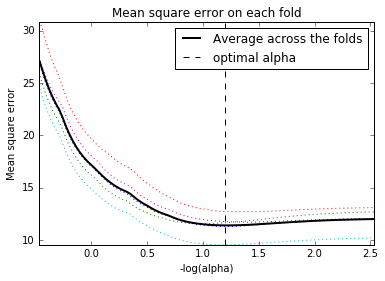

Optimal alpha: 0.06
Training R2 with Lasso: 0.596636
Training MSE with Lasso: 11.033356

Test R2 with Lasso: 0.561053
Test MSE with Lasso: 12.675927


In [53]:
#The code in this cell is partially borrowed from here: http://bit.ly/1JPHF2x
# LassoCV: 
model = LassoCV(cv=5).fit(X_train_train, Y_train_train)

# list of alphas that were tried-out
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='optimal alpha')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.show()

Y_predict = model.predict(X_train_train)
r2 = model.score(X_train_train, Y_train_train)
mse = mean_squared_error(Y_predict, Y_train_train)

print('Optimal alpha: {:.2f}'.format(model.alpha_))
print('Training R2 with Lasso: {:.6f}'.format(r2))
print('Training MSE with Lasso: {:.6f}'.format(mse))


Y_predict = model.predict(X_train_test)
r2 = model.score(X_train_test, Y_train_test)
mse = mean_squared_error(Y_predict, Y_train_test)

print('\nTest R2 with Lasso: {:.6f}'.format(r2))
print('Test MSE with Lasso: {:.6f}'.format(mse))



It turns out Lasso performs better when tested with unseen data! This example well illustrates the importance of setting apart a test set when possible to access the performance of different models!

### III-  Conclusion

We used Lasso regresssion to automatically select important features where 37 features were indentified to be important.

Random forrest classifier performed significantly better on the trainin set, where the performance was measured using 4-fold cross validation. Here are the measn square errors (MSE) and $R^2$ scores for three methods we tried for the whole of the data set:

Train| Lasso | OLR with Selected Features | Random Forrest
--- | --- | --- | --- 
MSE | 11.29 | 11.18 | 2.86 
R2 |  0.59 |  0.60 | 0.897

We also split the training data into test and training part with the dation of 4 to 1. Trained our models with the training set. Here are the performances for the unseen test data for Lasso and random forest regressors:

Test| Lasso  | Random Forrest
--- | --- | --- 
MSE | 12.67 | 19.33 
R2 |  0.56 | 0.33

As a result we chose to deploy the Lasso regression model. One thing to note is that the performance of the random forrest regressor could be enhanced by increasing the number of trees.

It would have been interesting to see if performance could be enhanced by a more detailed feature engineering that incorporates higher order terms and interactions between features. Also, trying an elastic net regularizatiom, which is a mixture of L1 and L2 type penalties could be interesting.

Let's perform prediction on the test data and save it to a file. We will use a random forrest model as stated above:

In [54]:
Y_test_rf = model_rf2.predict(X_test)
Y_test = model.predict(X_test)

In [55]:
with open('codetest_part1_out.txt','w') as f:
    for y in Y_test:
        f.write(str(y)+'\n')

Sanity check to make sure Lasso and random forrest result in similar estimations for the test data set

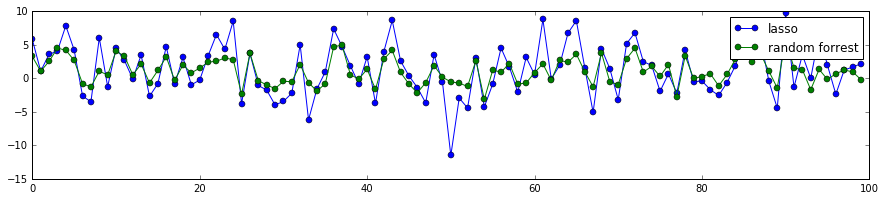

In [56]:
fig = plt.figure(figsize=(15,3))
plt.plot(Y_test[:100], '-o', label = 'lasso')
plt.plot(Y_test_rf[:100], '-o',color = 'g', label = 'random forrest')
plt.legend()
plt.show()

In [58]:
!ipython nbconvert regression_wo_knowing_feature_names.ipynb

[NbConvertApp] Converting notebook regression_wo_knowing_feature_names.ipynb to html
[NbConvertApp] Writing 523518 bytes to regression_wo_knowing_feature_names.html
